In [1]:
import numpy as np
import pandas as pd
import scipy.io as si
import os
import glob
import librosa
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint ,EarlyStopping
from keras.layers.wrappers import Bidirectional
from keras.utils.generic_utils import Progbar
from keras.layers.normalization import BatchNormalization
#from keras.utils.visualize_util import plot
from keras.layers import LSTM, Dropout, GRU,Conv1D, Convolution1D,  MaxPooling1D, Flatten,Reshape
from keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
import sys
import numpy
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[0], True)
import copy
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from scipy.io import savemat
import scipy.io.wavfile as wf
import sys
from keras.optimizers import SGD,Adam
import scipy.io
import collections
from keras.layers import Masking
import matplotlib.pyplot as plt
import Github_imp
import ntpath

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
mfccTotal = []
os.chdir('/home2/data/Manthan/008/101/MCEP')
for wavFile in sorted(glob.glob("spliced*.mat")):
    #print(wavFile)
    coded_sp=(si.loadmat(wavFile))['coded_sp']
    #print(wavFile)
    ap=(si.loadmat(wavFile))['ap']
    f0=(si.loadmat(wavFile))['f0']
    coded_sp=np.array(coded_sp)
    ap=np.transpose(np.array(ap))
    f0=np.array(f0)
    #coded_sp=(coded_sp-np.array(s_mean))/np.array(s_std)
    print(coded_sp.shape)
    #print(ap.shape)
    #print(f0.shape)
    y_framed=np.concatenate(( coded_sp,ap,f0),axis=0)
    coded_sp=np.transpose(coded_sp)
    #coded_sp_mean=np.mean(coded_sp,axis=0)
    #coded_sp_std=np.std(coded_sp,axis=0)
    #coded_sp=(coded_sp-coded_sp_mean)/coded_sp_std
    mfccTotal.append(coded_sp)

(25, 369)
(25, 325)
(25, 341)
(25, 291)
(25, 376)
(25, 285)
(25, 233)
(25, 263)
(25, 200)
(25, 342)
(25, 344)
(25, 484)
(25, 408)
(25, 246)
(25, 347)
(25, 402)
(25, 417)
(25, 280)
(25, 283)
(25, 263)
(25, 231)
(25, 311)
(25, 350)
(25, 243)
(25, 465)
(25, 415)
(25, 285)
(25, 312)
(25, 388)
(25, 344)
(25, 303)
(25, 181)
(25, 311)
(25, 374)
(25, 335)
(25, 258)
(25, 245)
(25, 385)
(25, 152)
(25, 324)
(25, 211)
(25, 383)
(25, 164)
(25, 244)
(25, 237)
(25, 350)
(25, 316)
(25, 332)
(25, 305)
(25, 364)
(25, 355)
(25, 285)
(25, 339)
(25, 259)
(25, 280)
(25, 324)
(25, 341)
(25, 280)
(25, 281)
(25, 291)
(25, 327)
(25, 420)
(25, 372)
(25, 294)
(25, 254)
(25, 274)
(25, 379)
(25, 350)
(25, 347)
(25, 307)
(25, 244)
(25, 225)
(25, 225)
(25, 379)
(25, 314)
(25, 267)
(25, 228)
(25, 385)
(25, 366)
(25, 321)
(25, 314)
(25, 257)
(25, 337)
(25, 276)
(25, 259)
(25, 280)
(25, 417)
(25, 279)
(25, 262)
(25, 356)
(25, 188)
(25, 410)
(25, 251)
(25, 273)
(25, 227)
(25, 331)
(25, 458)
(25, 270)
(25, 299)
(25, 375)


In [3]:
def double_average(x):
    assert len(x.shape) == 1
    f = np.ones(9)/9.0
    v = np.convolve(x, f, mode='same')
    w = np.convolve(v, f, mode='same')
    return w
def get_emg_features(emg_data,f_l,h_l):
    #print(emg_data.shape)
    x = emg_data - np.mean(emg_data)
    #x=emg_data
    frame_features = []
    #x = xs[:,i]
    #x=x[:,i]
    w = double_average(x)
    p = x - w
    r = np.abs(p)
    w_h = librosa.util.frame(w, frame_length=f_l, hop_length=h_l).mean(axis=0)
    p_w = librosa.feature.rms(w, frame_length=f_l, hop_length=h_l, center=False)
    p_w = np.squeeze(p_w, 0)
    p_r = librosa.feature.rms(r, frame_length=f_l, hop_length=h_l, center=False)
    p_r = np.squeeze(p_r, 0)
    z_p = librosa.feature.zero_crossing_rate(p, frame_length=f_l, hop_length=h_l, center=False)
    z_p = np.squeeze(z_p, 0)
    r_h = librosa.util.frame(r, frame_length=f_l, hop_length=h_l).mean(axis=0)
    frame_features.append(np.stack([w_h, p_w, p_r, z_p, r_h], axis=1))
    #frame_features.append(np.stack([p_w, p_r,z_p, r_h], axis=1))
    frame_features = np.concatenate(frame_features, axis=1)
    return frame_features.astype(np.float32)

In [4]:
Emg_Fs = 600
window_size =int(32*0.001*Emg_Fs)
Hop_len = int(10*0.001*Emg_Fs)
outputdim = Hop_len
window = Hop_len
n_feats=5
TTmax = 550
no_emg=6
TDTotal = []
emgTotal = []
HilbertTotal =[]
emg_path="/home2/data/Manthan/008/101/"
HilbertPath="/home2/data/Manthan/008/101/ProcessedDavella/UKA/"
#TD EMG
emgTotal=[]
os.chdir("/home2/data/Manthan/008/101/")
for emgFile in sorted(glob.glob('spliced*.mat')):
    cur_emg=scipy.io.loadmat(emgFile)
    
    cur_emg=cur_emg['ADC_modified']
    cur_emg=cur_emg[:6,:]
    cur_emg=np.transpose(cur_emg)
    count = ntpath.basename(emgFile)
    #print(count)
    hilbertmat = si.loadmat(HilbertPath+count)
    Hilfeat = np.array(hilbertmat['data']) ##hilbert
    #print(Hilfeat)
    #Hilfeat = np.reshape(Hilfeat,(len(Hilfeat),1))
    #print(Hilfeat.shape)
    cur_emg_td=Github_imp.get_emg_features(cur_emg)
    #print(cur_emg_td.shape)
    mean=np.mean(cur_emg_td,axis=0)
    std=np.std(cur_emg_td,axis=0)
    cur_emg_td=(cur_emg_td-mean)/std
    TDTotal.append(cur_emg_td)
    Hilfeat_1= (Hilfeat-np.mean(Hilfeat,axis=0))/np.std(Hilfeat,axis=0)
    HilbertTotal.append(Hilfeat_1)
    #emgTotal.append(cur_emg_td)
    #print(cur_emg_td.shape)
print("EMG DONE")

for i in range(len(mfccTotal)):
    #print(i,len(emgTotal[i]))
    #print(len(TDTotal[i]))
    print('orig',len(TDTotal[i]),len(mfccTotal[i]))
    if(len(mfccTotal[i]) > len(TDTotal[i])):
        subLen = len(mfccTotal[i]) - len(TDTotal[i])
        change = len(mfccTotal[i]) - subLen
        mfccTotal[i] = mfccTotal[i][:change,:]     
    if(len(TDTotal[i]) > len(mfccTotal[i])):
        subLen = len(TDTotal[i]) - len(mfccTotal[i])
        change = len(TDTotal[i]) - subLen
        TDTotal[i] = TDTotal[i][:change][:]
    #print(i,len(emgTotal[i]))
    #print(len(TDTotal[i]))
    print('new',len(TDTotal[i]),len(mfccTotal[i]))
    
print("*******************Now Hilbert********************")
for i in range(len(mfccTotal)):
    #print(i,len(emgTotal[i]))
    #print(len(HilbertTotal[i]))
    print('orig',len(HilbertTotal[i]),len(mfccTotal[i]))
    if(len(mfccTotal[i]) > len(HilbertTotal[i])):
        subLen = len(mfccTotal[i]) - len(HilbertTotal[i])
        change = len(mfccTotal[i]) - subLen
        mfccTotal[i] = mfccTotal[i][:change,:]     
    if(len(HilbertTotal[i]) > len(mfccTotal[i])):
        subLen = len(HilbertTotal[i]) - len(mfccTotal[i])
        change = len(HilbertTotal[i]) - subLen
        HilbertTotal[i] = HilbertTotal[i][:change][:]
    print('new',len(HilbertTotal[i]),len(mfccTotal[i]))


EMG DONE
orig 367 369
new 367 367
orig 322 325
new 322 322
orig 338 341
new 338 338
orig 289 291
new 289 289
orig 373 376
new 373 373
orig 282 285
new 282 282
orig 231 233
new 231 231
orig 260 263
new 260 260
orig 197 200
new 197 197
orig 340 342
new 340 340
orig 341 344
new 341 341
orig 481 484
new 481 481
orig 405 408
new 405 405
orig 244 246
new 244 244
orig 345 347
new 345 345
orig 399 402
new 399 399
orig 415 417
new 415 415
orig 277 280
new 277 277
orig 281 283
new 281 281
orig 260 263
new 260 260
orig 229 231
new 229 229
orig 309 311
new 309 309
orig 348 350
new 348 348
orig 241 243
new 241 241
orig 462 465
new 462 462
orig 413 415
new 413 413
orig 282 285
new 282 282
orig 309 312
new 309 309
orig 386 388
new 386 386
orig 341 344
new 341 341
orig 300 303
new 300 300
orig 178 181
new 178 178
orig 308 311
new 308 308
orig 372 374
new 372 372
orig 333 335
new 333 333
orig 256 258
new 256 256
orig 242 245
new 242 242
orig 383 385
new 383 383
orig 149 152
new 149 149
orig 322 324
new

orig 254 252
new 252 252
orig 481 478
new 478 478
orig 305 303
new 303 303
orig 269 267
new 267 267
orig 375 373
new 373 373
orig 257 254
new 254 254
orig 394 392
new 392 392
orig 454 451
new 451 451
orig 305 302
new 302 302
orig 391 389
new 389 389
orig 345 342
new 342 342
orig 400 397
new 397 397
orig 215 213
new 213 213
orig 416 414
new 414 414
orig 299 296
new 296 296
orig 203 201
new 201 201
orig 207 205
new 205 205
orig 192 190
new 190 190
orig 369 366
new 366 366
orig 259 257
new 257 257
orig 394 392
new 392 392
orig 321 318
new 318 318
orig 157 155
new 155 155
orig 455 453
new 453 453
orig 383 381
new 381 381
orig 317 315
new 315 315
orig 288 286
new 286 286
orig 367 365
new 365 365
orig 282 280
new 280 280
orig 348 345
new 345 345
orig 458 456
new 456 456
orig 360 358
new 358 358
orig 311 308
new 308 308
orig 269 267
new 267 267
orig 256 254
new 254 254
orig 295 293
new 293 293
orig 308 305
new 305 305
orig 311 309
new 309 309
orig 216 213
new 213 213
orig 301 298
new 298 298


In [5]:
TDCalc = copy.deepcopy(TDTotal)
HilbCalc = copy.deepcopy(HilbertTotal)

X1 = np.asarray(TDCalc)
X2 = np.asarray(HilbCalc)
y=mfccTotal

In [6]:
print(X1[0].shape)
print(X2[0].shape)

(367, 30)
(367, 6)


In [7]:
from sklearn.model_selection import train_test_split
XP_td,X1_test_td, YP, y_test = train_test_split(X1, y, test_size = 0.05, random_state=42)
X_train_td,X_val_td, Y_train, Y_val = train_test_split(XP_td, YP, test_size = 0.05, random_state=42)

In [8]:
XP_h,X1_test_h, YP, y_test = train_test_split(X2, y, test_size = 0.05, random_state=42)
X_train_h,X_val_h, Y_train, Y_val = train_test_split(XP_h, YP, test_size = 0.05, random_state=42)

In [9]:
print(X_train_td.shape)
print(X_train_h.shape)

(458,)
(458,)


In [10]:
for i in range(len(X_train_td)):
    X_train_td[i] = np.transpose(X_train_td[i])
    X_train_h[i] = np.transpose(X_train_h[i])
    Y_train[i] = np.transpose(Y_train[i])

for j in range(len(X_val_td)):
    X_val_td[j] = np.transpose(X_val_td[j])
    X_val_h[j] = np.transpose(X_val_h[j])
    Y_val[j] = np.transpose(Y_val[j])

In [11]:
TT_max=490#np.max(TT_Total)


for i in range(len(X_val_td)):
    X_val_td[i] = np.transpose(pad_sequences(X_val_td[i], padding='post',maxlen=TT_max,dtype='float'))
    X_val_h[i] = np.transpose(pad_sequences(X_val_h[i], padding='post',maxlen=TT_max,dtype='float'))

for i in range(len(X_train_td)):
    X_train_td[i] = np.transpose(pad_sequences(X_train_td[i], padding='post',maxlen=TT_max,dtype='float'))
    X_train_h[i] = np.transpose(pad_sequences(X_train_h[i], padding='post',maxlen=TT_max,dtype='float'))
    
for i in range(len(Y_train)):
    Y_train[i] = np.transpose(pad_sequences(Y_train[i], padding='post',maxlen=TT_max,dtype='float'))

for i in range(len(Y_val)):
    Y_val[i] = np.transpose(pad_sequences(Y_val[i], padding='post',maxlen=TT_max,dtype='float'))

In [12]:
OutDir = '/home2/data/Manthan/UKA_Corpus/MCEP/'

In [13]:
Y_train=np.array(Y_train)
y_test=np.array(y_test)
Y_val=np.array(Y_val)

In [14]:
NoUnits=128 #LSTM units
BatchSize=32
NoEpoch=75
std_frac=0.25
n_mfcc=25
inputDim_1=30
inputDim_2=6

In [15]:
print('..compiling model')
mdninput_Lstm_td= keras.Input(shape=(None,inputDim_1))
mdninput_Lstm_hilb=keras.Input(shape=(None,inputDim_2))
#c1=Conv1D(filters = 16, kernel_size=(5), strides=1, padding="same", activation='tanh')(mdninput_Lstm_td)
#c2=Conv1D(filters = 32, kernel_size=(3), strides=1, padding="same", activation='tanh')(c1)
#c3=Conv1D(filters = 64, kernel_size=(3), strides=1, padding="same", activation='tanh')(c2)
mdninput_Lstm_1= Masking(mask_value=0.)(mdninput_Lstm_td)
lstm_1=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh', dropout = 0.2))(mdninput_Lstm_1)
lstm_2a=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh', dropout = 0.2))(lstm_1)
mdninput_Lstm_2= Masking(mask_value=0.)(mdninput_Lstm_hilb)
lstm_2=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh',dropout = 0.2))(mdninput_Lstm_2)
concate_layer = tf.keras.layers.Concatenate(axis=-1)([lstm_2a, lstm_2])
#lstm_2b=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh',dropout = 0.4))(lstm_2)
#lstm_2c=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh',dropout = 0.2))(lstm_2b)
#lstm_2d=Bidirectional(LSTM(NoUnits, return_sequences=True,activation='tanh',dropout = 0.2))(lstm_2c)
lstm_2c=Bidirectional(LSTM(128, return_sequences=True,activation='tanh',dropout = 0.2))(concate_layer)
op =TimeDistributed(Dense(n_mfcc, activation='linear'))(lstm_2c)
#output=TimeDistributed(Dense(n_mfcc, activation='linear'))(lstm_2)
model = keras.models.Model(inputs=[mdninput_Lstm_td,mdninput_Lstm_hilb],outputs=op)
model.summary()
print('\n\nModel with input size {}, output size {}'.format(model.input_shape, model.output_shape))

..compiling model
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 30)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 256)    162816      masking[0][0]                    
_____________________________________________________________________

In [16]:
model.compile(optimizer='adam', loss='mse')

In [17]:
OutFileName='008_Trial_3_18_June_BLSTM'+'Batch'+ str(BatchSize)+'_'+'_LSTMunits_pred'+str(NoUnits)+'_'+'_Sent_Norm_'
fName=OutFileName

In [18]:
X_train_1_td=[]
X_train_1_h=[]
Y_train_1=[]
X_val_1_td=[]
X_val_1_h=[]
Y_val_1=[]
print(X_train_h.shape)
for i in range(len(X_train_td)):
        X_train_1_td.append(np.array(X_train_td[i]))
        X_train_1_h.append(np.array(X_train_h[i]))
        Y_train_1.append(np.array(Y_train[i]))
for i in range(len(X_val_td)):
        X_val_1_td.append(np.array(X_val_td[i]))
        X_val_1_h.append(np.array(X_val_h[i]))
        Y_val_1.append(np.array(Y_val[i]))

(458,)


In [19]:
print('..fitting model')

checkpointer = ModelCheckpoint(filepath=OutDir+fName + '_.h5', verbose=0, save_best_only=True)
checkpointer1 = ModelCheckpoint(filepath=OutDir+fName + '_weights.h5', verbose=0, save_best_only=True, save_weights_only=True)
earlystopper =EarlyStopping(monitor='val_loss', patience=5)
history=model.fit([np.array(X_train_1_td),np.array(X_train_1_h)],np.array(Y_train_1),validation_data=([np.array(X_val_1_td),np.array(X_val_1_h)],np.array(Y_val_1)),epochs=NoEpoch, batch_size=BatchSize,verbose=1,shuffle=True,callbacks=[checkpointer,checkpointer1,earlystopper])


..fitting model
Epoch 1/75
15/15 [==============================] - 11s 764ms/step - loss: 1.7512 - val_loss: 0.3913
Epoch 2/75
15/15 [==============================] - 2s 162ms/step - loss: 0.2995 - val_loss: 0.2469
Epoch 3/75
15/15 [==============================] - 2s 155ms/step - loss: 0.2267 - val_loss: 0.2085
Epoch 4/75
15/15 [==============================] - 2s 156ms/step - loss: 0.1969 - val_loss: 0.1935
Epoch 5/75
15/15 [==============================] - 2s 158ms/step - loss: 0.1861 - val_loss: 0.1836
Epoch 6/75
15/15 [==============================] - 2s 151ms/step - loss: 0.1759 - val_loss: 0.1722
Epoch 7/75
15/15 [==============================] - 3s 174ms/step - loss: 0.1661 - val_loss: 0.1643
Epoch 8/75
15/15 [==============================] - 2s 150ms/step - loss: 0.1591 - val_loss: 0.1590
Epoch 9/75
15/15 [==============================] - 2s 156ms/step - loss: 0.1537 - val_loss: 0.1535
Epoch 10/75
15/15 [==============================] - 2s 155ms/step - loss: 0.1473 -

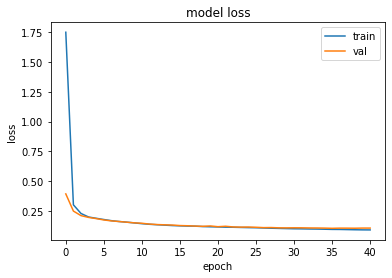

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
#plt.savefig(OutDir+OutFileName+'foo.png')

In [21]:
X_test_td = []
X_test_h = []
Y_test = []
for i in np.arange(0,len(y_test)):
            E_t = y_test[i]
            M_t_td = X1_test_td[i]
            M_t_h = X1_test_h[i]
            #W_t=W_t[np.newaxis,:,:,np.newaxis]
            E_t=E_t[np.newaxis,:,:]
            M_t_td=M_t_td[np.newaxis,:,:]
            M_t_h=M_t_h[np.newaxis,:,:]
            Y_test.append(E_t)
            X_test_td.append(M_t_td)
            X_test_h.append(M_t_h)

In [22]:
yPred = []
print(len(X_test_td))
for x in range(len(X_test_td)):
    print(X_test_td[x].shape[1])
    y_pred = model.predict([X_test_td[x],X_test_h[x]])
    yPred.append(y_pred)
    print("done")

26
319
done
265
done
341
done
249
done
389
done
248
done
292
done
365
done
257
done
260
done
376
done
219
done
300
done
344
done
242
done
312
done
350
done
300
done
340
done
322
done
268
done
320
done
229
done
208
done
296
done
277
done


In [23]:
for i in range(len(yPred)):
    yPred[i] = np.squeeze(yPred[i],axis=0)
    Y_test[i] = np.squeeze(Y_test[i],axis=0)

In [24]:
h=model.get_weights()
si.savemat(OutDir+OutFileName+'out_.mat', {'weights':h, 'Test_Predicted':yPred, 'Test_target':Y_test})

In [25]:
print("Ho gya")

Ho gya
